# YOLOv8 Model Training on Custom Dataset

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from ultralytics import YOLO
from IPython.display import display, Image

import sys
sys.path.append("../") # Set parent directory to sys.path
sys.dont_write_bytecode = True
%load_ext autoreload
%autoreload 2
import src.utils as utils

palette0 = sns.color_palette(['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']) # Okabe-Ito
palette = palette0
display(palette)
# sns.set_theme(context='poster', style='ticks', palette=palette, font_scale=1.00) # very good to see
sns.set_theme(context='poster', style='ticks', palette=palette, font_scale=0.70) # very good to see

[(0.9019607843137255, 0.6235294117647059, 0.0),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.0, 0.4470588235294118, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.0, 0.0, 0.0)]

In [2]:
!nvidia-smi
num_gpus = torch.cuda.device_count()
for i in range(num_gpus):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")

Thu Oct 17 06:33:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   60C    P0             92W /  300W |   40481MiB /  49140MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
current_directory = os.getcwd()
print(current_directory)

# We used this in the paper!
DATA_DIR = "/mnt/nfs_p/yolo/umineko-2024-v8i-yolov8" # 90:9:1 split, w/ data augmentation 3x

os.chdir(DATA_DIR)
current_directory = os.getcwd()
print(current_directory)

/mnt/code/umineko-seg-dev/notebooks
/mnt/nfs_p/yolo/umineko-2024-v8i-yolov8


# Custom Training

## Training on custom dataset

In [ ]:
# N_EPOCHS = 3
# N_EPOCHS = 10
# N_EPOCHS = 100
# N_EPOCHS = 150
# N_EPOCHS = 200
# N_EPOCHS = 250
N_EPOCHS = 300

# PATIENCE = N_EPOCHS
PATIENCE = 50

IMGSZ = 640
BATCH_SIZE = 16

DEVICE_ID = 0
# DEVICE_ID = 1

RANDOM_SEED = 0

In [ ]:
# !yolo task=segment mode=train model=yolov8s-seg.pt data={DATA_DIR}/data.yaml epochs=3 imgsz=640

# Load a model
WEIGHTS_PATH = "yolov8s-seg.pt"
model = YOLO(WEIGHTS_PATH)  # load a pretrained model (recommended for training)

### Run Training

In [ ]:
# Train the model
DATA_PATH = f"{DATA_DIR}/data.yaml"
results = model.train(
    data=DATA_PATH, 
    epochs=N_EPOCHS, 
    patience=PATIENCE, 
    imgsz=IMGSZ, 
    batch=BATCH_SIZE, 
    save=True, 
    save_period=10, # save every 10 epochs 
    # device=DEVICE_ID,
    workers=8, 
    project=f'{DATA_DIR}/output/train/runs', 
    name=f"seed-{RANDOM_SEED:02}", 
    seed=RANDOM_SEED, 
    cls=0.5, 
    val=True, 
    plots=True
)

# Validation

In [ ]:
VAL_DIR = f"{DATA_DIR}/output/"
os.makedirs(VAL_DIR, exist_ok=True)
os.chdir(VAL_DIR)

# Load a model
WEIGHTS_PATH = "yolov8s-seg.pt"
model = YOLO(WEIGHTS_PATH)  # load an official model
model = YOLO(f"{DATA_DIR}/output/train/runs/seed-00/weights/best.pt")  # load a custom model

In [ ]:
# Validate the model
# val_metrics = model.val(device='cuda:0', plots=False, split='val')
# val_metrics = model.val(plots=True, split='val')
val_metrics = model.val(plots=False, split='val')

In [ ]:
print(f"MAP 50-95 = {val_metrics.seg.map:.4f}")    # map50-95
print(f"MAP 50    = {val_metrics.seg.map50:.4f}")  # map50
print(f"MAP 75    = {val_metrics.seg.map75:.4f}")  # map50-95
print(f"{val_metrics.seg.maps}")  # a list contains map50-95 of each category

# Testing

In [ ]:
TEST_DIR = f"{DATA_DIR}/output/"
os.makedirs(TEST_DIR, exist_ok=True)
os.chdir(TEST_DIR)

# Load a model
WEIGHTS_PATH = "yolov8s-seg.pt"
model = YOLO(WEIGHTS_PATH)  # load an official model
model = YOLO(f"{DATA_DIR}/output/train/runs/seed-00/weights/best.pt")  # load a custom model

In [ ]:
# Test the model
# test_metrics = model.val(device='cuda:0', plots=True, split='test')  # no arguments needed, dataset and settings remembered
test_metrics = model.val(device='cuda:0', plots=False, split='test')  # no arguments needed, dataset and settings remembered

In [ ]:
print(f"MAP 50-95 = {test_metrics.seg.map:.4f}")  # map50-95
print(f"MAP 50    = {test_metrics.seg.map50:.4f}")  # map50
print(f"MAP 75    = {test_metrics.seg.map75:.4f}")  # map50-95
print(f"{test_metrics.seg.maps}")  # a list contains map50-95 of each category

## Show masked images

In [34]:
# Select mask color
# color = [255, 255, 0] # Cyan
# color = [255, 0, 255] # Magenta
# color = [0, 255, 255] # Yellow
# color = [0, 255, 0]   # Green

# Okabe-Ito
# color = np.array([0, 159, 230])   # orange
# color = np.array([233, 180, 86])  # lightblue
# color = np.array([115, 158, 0])   # green
# color = np.array([66, 228, 240])  # yellow
# color = np.array([178, 114, 0])   # blue
# color = np.array([0, 94, 213])    # red
color = np.array([167, 121, 204]) # pink

In [6]:
DATA_DIR = "/mnt/nfs_p/yolo/umineko-2024-v8i-yolov8" # 90:9:1 split, w/ data augmentation 3x

In [7]:
# Load a model
WEIGHTS_PATH = "yolov8s-seg.pt"
model = YOLO(WEIGHTS_PATH)  # load an official model to initialize the weights
model = YOLO(f"{DATA_DIR}/output/train/runs/seed-00/weights/best.pt")  # load the weights from the custom-trained model

In [32]:
test_image_list = sorted(glob.glob(f"{DATA_DIR}/test/images/*.jpg"))
print(len(test_image_list))
random.seed(1)
indices = sorted(random.sample(range(len(test_image_list)), 10))
print(indices)

IMG_DIR = "/mnt/nfs_p/yolo/figure-01/"
os.chdir(IMG_DIR)
current_directory = os.getcwd()
print(current_directory)
test_image_list = sorted(glob.glob(f"{IMG_DIR}/original/*.jpg"))
print(len(test_image_list))
random.seed(1)
indices = sorted(random.sample(range(len(test_image_list)), 5))
print(indices)

31
[2, 3, 4, 8, 14, 15, 18, 24, 25, 27]
/mnt/nfs_p/yolo/figure-01
5
[0, 1, 2, 3, 4]



image 1/1 /mnt/nfs_p/yolo/figure-01/original/lbp03_s00_frame_01800.jpg: 480x640 (no detections), 7.5ms
Speed: 0.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict2


Number of pixels in the class 0: 0 (0.0%)


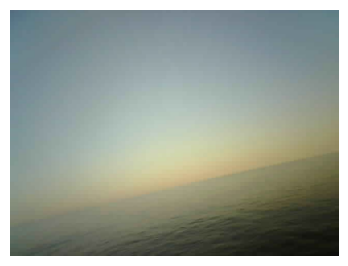

lbp03_s00_frame_01800.jpg


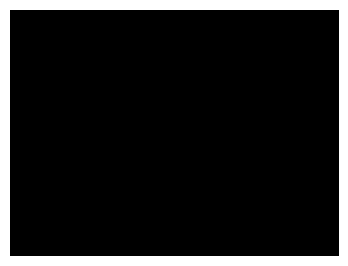

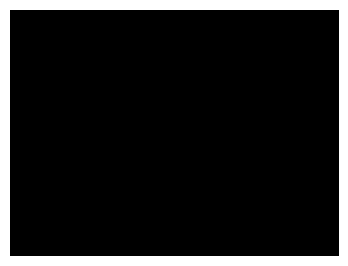


image 1/1 /mnt/nfs_p/yolo/figure-01/original/lbp03_s00_frame_01938.jpg: 480x640 1 bird, 5.9ms
Speed: 0.7ms preprocess, 5.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict2


Number of pixels in the class 0: 127,492 (41.5%)


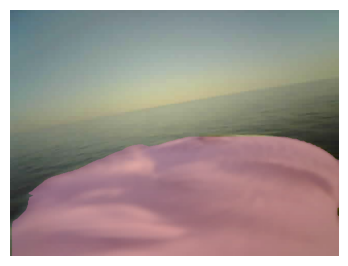

lbp03_s00_frame_01938.jpg


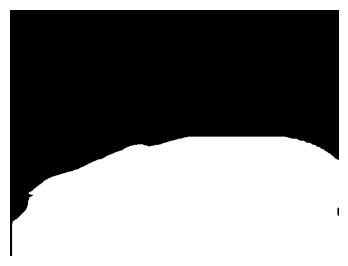

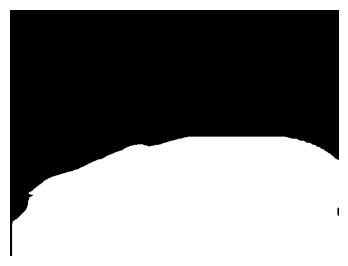


image 1/1 /mnt/nfs_p/yolo/figure-01/original/lbp03_s00_frame_01940.jpg: 480x640 1 bird, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict2


Number of pixels in the class 0: 158,475 (51.6%)


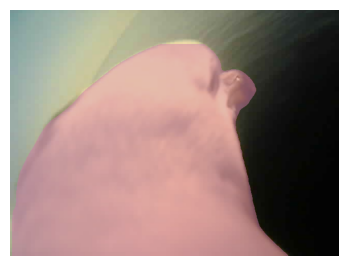

lbp03_s00_frame_01940.jpg


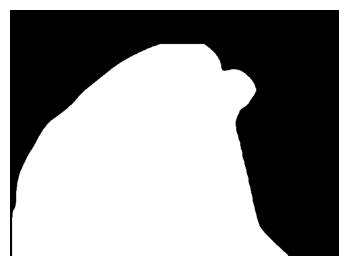

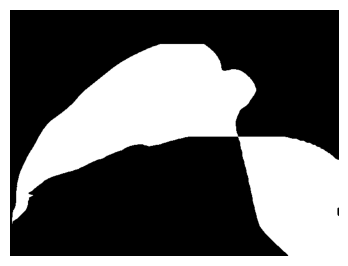


image 1/1 /mnt/nfs_p/yolo/figure-01/original/lbp03_s00_frame_01943.jpg: 480x640 1 bird, 6.8ms
Speed: 0.8ms preprocess, 6.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict2


Number of pixels in the class 0: 34,122 (11.1%)


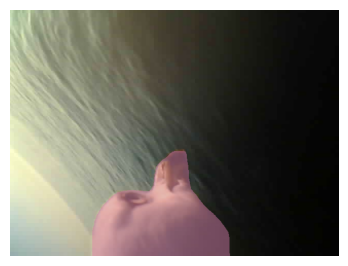

lbp03_s00_frame_01943.jpg


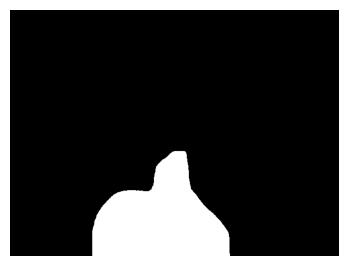

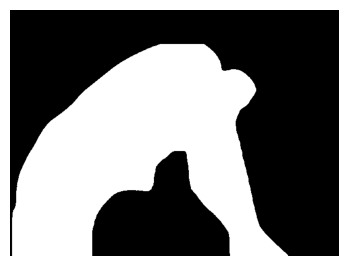


image 1/1 /mnt/nfs_p/yolo/figure-01/original/lbp03_s00_frame_02200.jpg: 480x640 (no detections), 7.0ms
Speed: 0.8ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict2


Number of pixels in the class 0: 0 (0.0%)


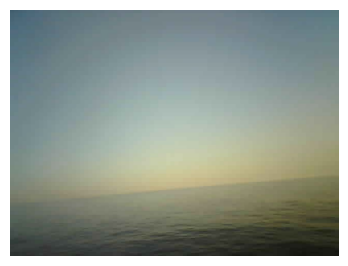

lbp03_s00_frame_02200.jpg


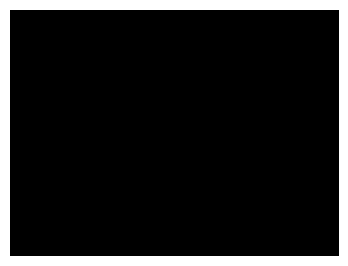

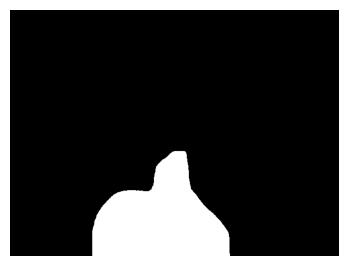

In [42]:
mask_color = np.array([167, 121, 204])  # pink
DEVICE = 'cuda:0'
# DEVICE = 'cuda:1'
# DEVICE = 'cpu'
prev_results = None
threshold = 0.5
null_mask = np.zeros((480, 640), dtype=np.float32)
prev_mask = null_mask
pixel_count_list = []
diff_pixel_count_list = []
for i, index in enumerate(indices):
    image_path = test_image_list[index]
    image = cv2.imread(image_path)
    results = model.predict(image_path, save=True, imgsz=640, conf=0.5, device=DEVICE)
    show_masked_image = True
    curr_mask, pixel_count, fig = utils.create_masked_image(
        results, image, mask_color=mask_color, alpha=0.5, show=show_masked_image
    )
    pixel_count_list.append(pixel_count)
    # print(curr_mask.dtype)
    # print(curr_mask.shape)
    
    # Calculate difference
    diff_mask = cv2.absdiff(curr_mask, prev_mask)
    diff_pixel_count = 0 if i == 0 else np.sum(diff_mask > threshold) 
    diff_pixel_count_list.append(diff_pixel_count)
    prev_mask = curr_mask # update previous mask
    
    filename = os.path.basename(image_path)
    print(filename)
    fig.savefig(f"{IMG_DIR}/masked/masked_{filename}", bbox_inches='tight', pad_inches=0.0, transparent=True)
    
    fig = utils.vis_mask_in_black_and_white(curr_mask)
    fig.savefig(f"{IMG_DIR}/masked/mask_bw_{filename}", bbox_inches='tight', pad_inches=0.05, transparent=False)
    fig = utils.vis_mask_in_black_and_white(diff_mask)
    fig.savefig(f"{IMG_DIR}/masked/diff_mask_bw_{filename}", bbox_inches='tight', pad_inches=0.05, transparent=False)